In [143]:
using PyPlot
using JuMP, Ipopt
using Random
using Distributions

Random.seed!(2);

In [144]:
include("../src/model.jl");
include("../src/diagnostics.jl");
include("../src/optimization.jl");
include("../src/plotting.jl");
include("../src/defaults.jl");

include("../src/stochastic_emissions.jl");

rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams");
rcParams["lines.linestyle"] = "-";

In [145]:
ensemble = Dict()
Δt = 25.
δq = 7.5

model = ClimateModel();
optimize_controls!(model);
ensemble[string(Int64(model.present_year))] = deep_copy(model);

Benefits were high enough (139.04196866243615 trillion USD > 50.0 trillion USD) to merit switching policies.
Benefits were NOT high enough (-97.59492682454652 trillion USD < 50.0 trillion USD) to merit switching policies.


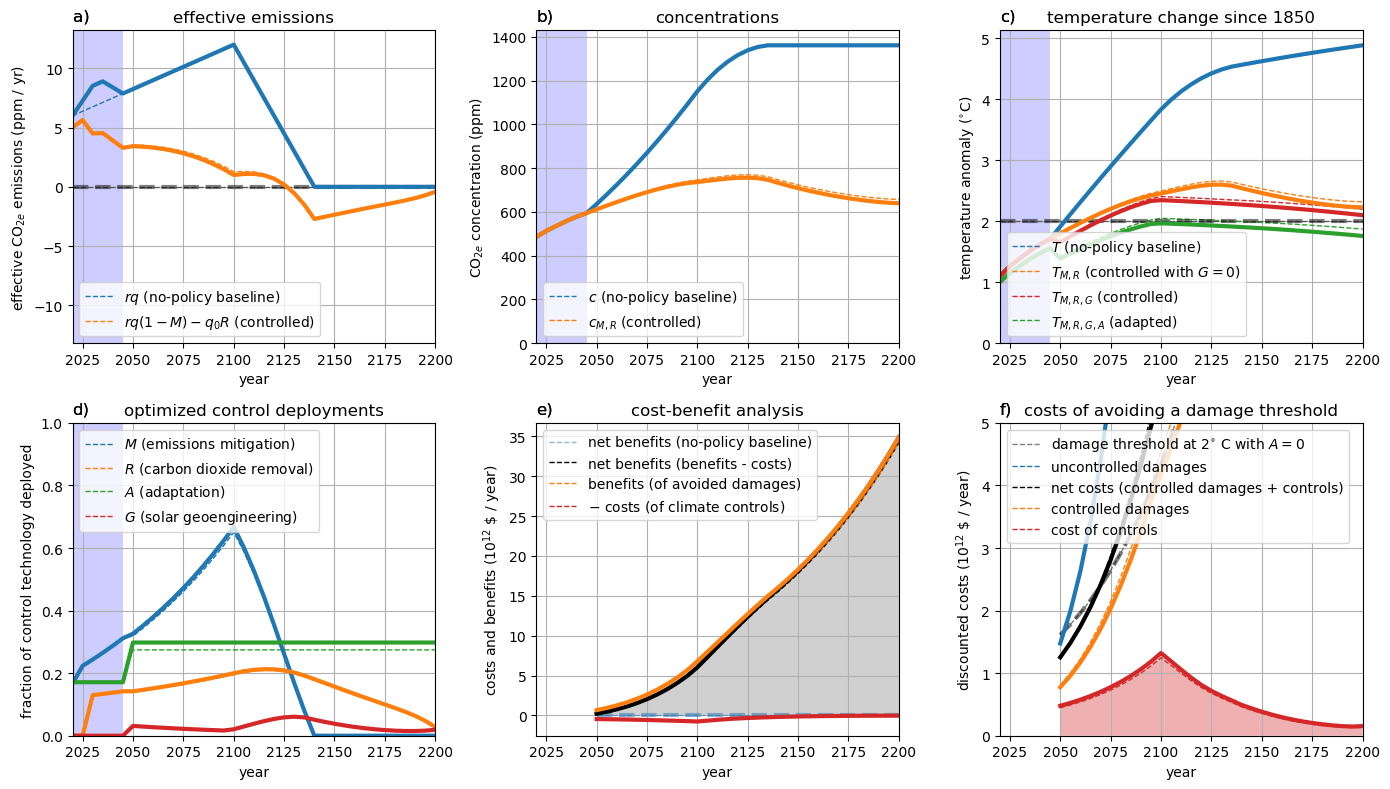

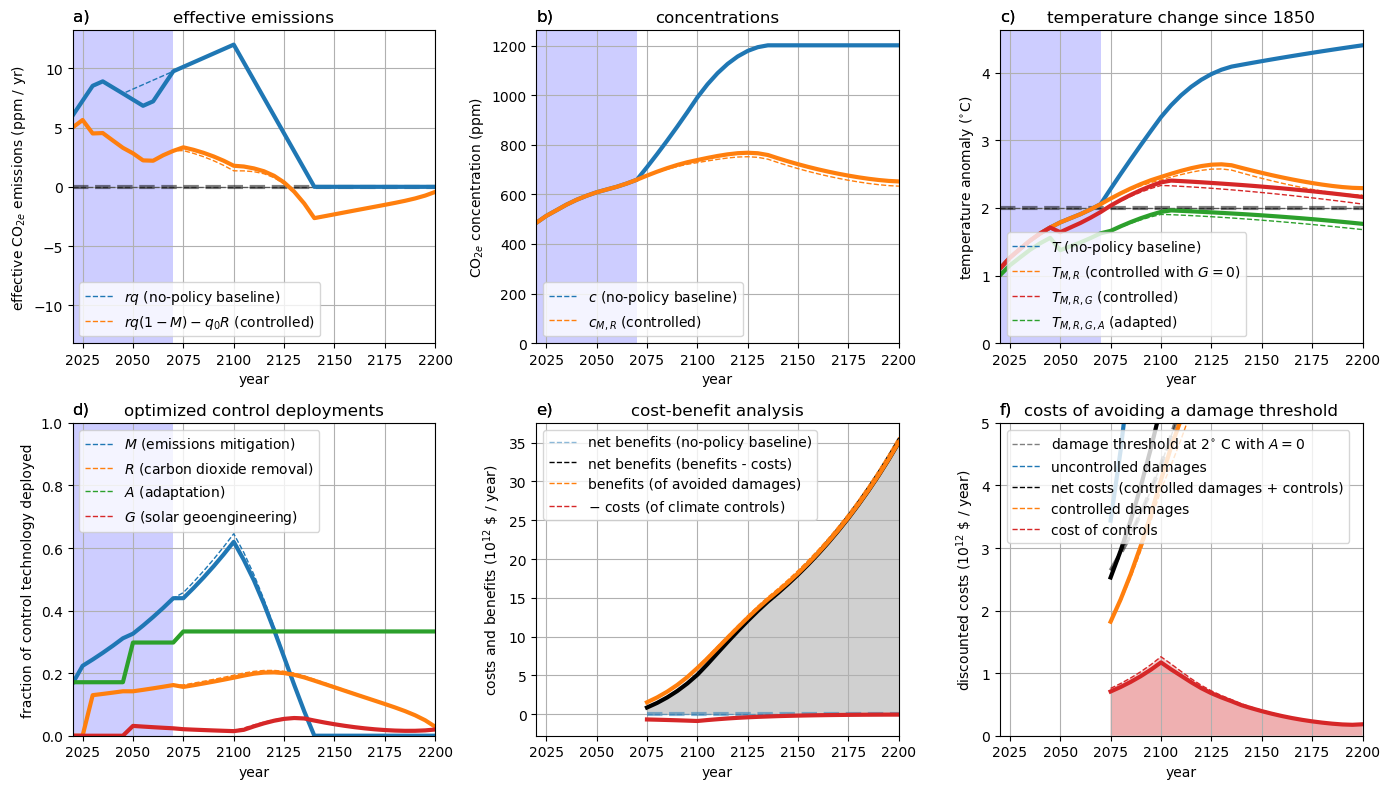

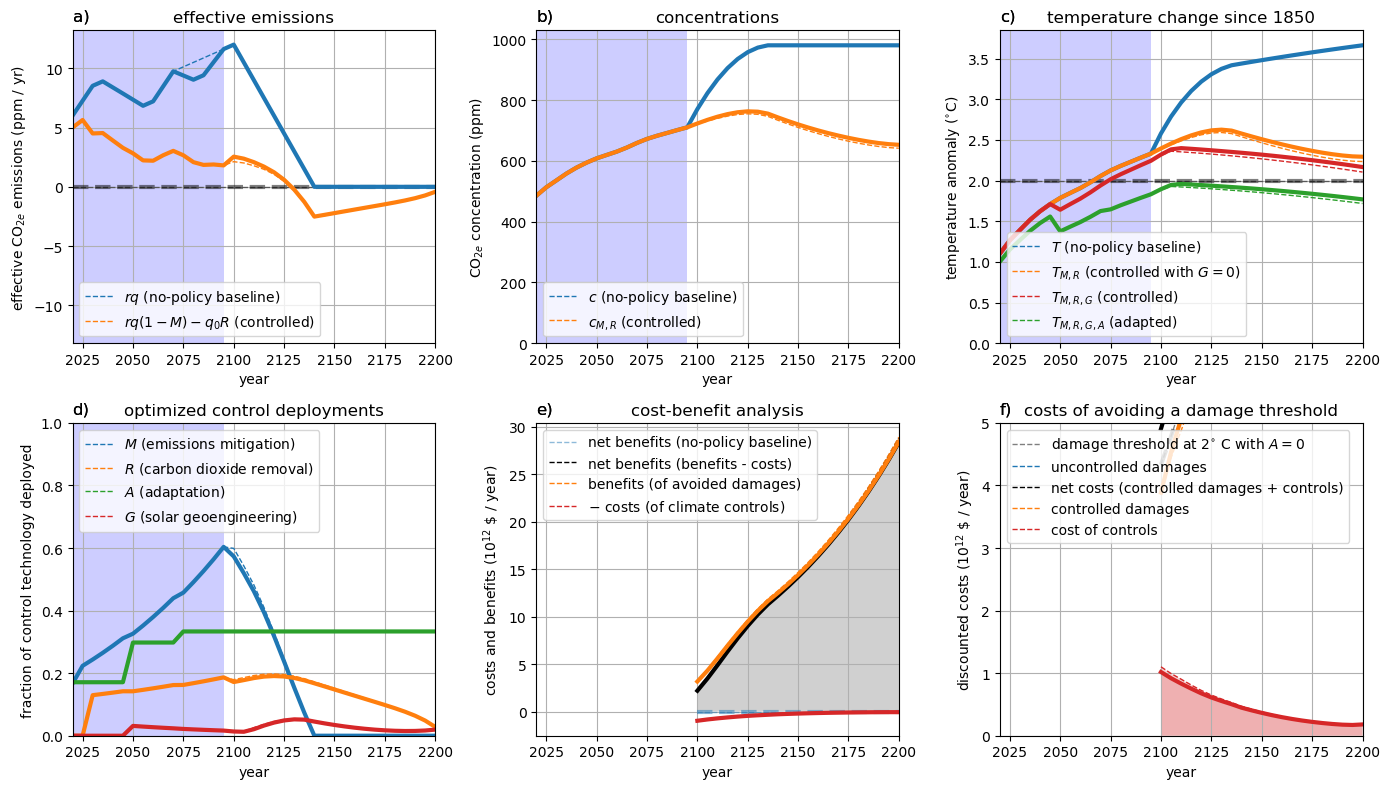

Benefits were NOT high enough (-56.53471448860773 trillion USD < 50.0 trillion USD) to merit switching policies.


In [146]:
d = Normal(0., δq)
Δq_samples = rand(d, 3)

previous_year = deepcopy(model.present_year)
for (step, Δq) in enumerate(Δq_samples)
    control_name = deepcopy(string(Int64(model.present_year + Δt), "_control"))

    # optimize before adding emissions
    control = deep_copy(model)
    step_forward!(control, Δt)
    mcontrol = optimize_controls!(control);
    add_emissions_bump!(control, Δt, Δq, present_year = control.present_year - Δt)
    ensemble[control_name] = control
    
    
    rcParams["lines.linestyle"] = "--"
    rcParams["lines.linewidth"] = 1.0
    plot_state(control)
    subplot(2,3,1)
    plot(model.domain, effective_baseline_emissions(model), "C0--")
    
    # optimize after adding emissions
    add_emissions_bump!(model, Δt, Δq)
    step_forward!(model, Δt)
    m = optimize_controls!(model);
    
    rcParams["lines.linestyle"] = "-"
    rcParams["lines.linewidth"] = 3.0
    plot_state(model, new_figure=false, plot_legends=false)
    ylim([0,5])
    
    ensemble[model.name] = deep_copy(model);
    
    switch_benefit = total_cost(control) - total_cost(model)
    
    threshold_benefit = 50.
    if (switch_benefit < threshold_benefit)
        println("Benefits were NOT high enough ($(switch_benefit) trillion USD < $(threshold_benefit) trillion USD) to merit switching policies.")
        model = control
    elseif (raw_status(m) != "Solve_Succeeded")
        println("No solution that meets the constraints.")
        model = control
    else
        println("Benefits were high enough ($(switch_benefit) trillion USD > $(threshold_benefit) trillion USD) to merit switching policies.")
    end
end